In [2]:
###库#####################################################################
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import graphviz
from time import time
import random
import pydotplus 
import os
import re
import jieba
from numpy.random import randn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  #'all'|'last'|'last_expr'|'none'
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

input_path = '../input/'
submi_path = '../submision/'

########################################################################
###特征预处理
def age_group(age):
    #用法：ori_data_28['age_group'] = ori_data_28.age.apply(age_group)
    if (age>=0) and (age<=10):
        return 0
    elif (age>10) and (age<=20):
        return 1
    elif (age>20) and (age<=30):
        return 2
    elif (age>30) and (age<=40):
        return 3
    elif (age>4) and (age<=50):
        return 4
    elif (age>50) and (age<=60):
        return 5
    elif (age>60) and (age<=70):
        return 6
    elif (age>70) and (age<=80):
        return 7
    elif (age>80) and (age<=90):
        return 8
    elif (age>90):
        return 9
def encode_count(df, encoder_list):
    lbl = LabelEncoder()
    for i in range(0, len(encoder_list)):
        df[[encoder_list[i]]] = lbl.fit_transform(df[[encoder_list[i]]])
    return df
def encode_onehot(df, oneHot_list):
    for i in range(0, len(oneHot_list)):
        feature_df = pd.get_dummies(df[oneHot_list[i]], prefix=oneHot_list[i])
        df = pd.concat([df.drop([oneHot_list[i]], axis=1), feature_df], axis=1)
    return df
def normalize(df, normalize_list):
    scaler = StandardScaler()
    for i in range(0, len(normalize_list)):
        df[[normalize_list[i]]] = scaler.fit_transform(df[[normalize_list[i]]])
    return df

###制作统计特征
def feat_nunique(df_tar, df_fea, grou, stati, name, na=0):
    add_tem = df_fea.groupby(grou)[stati].nunique().reset_index().rename(columns={stati[0]: name[0]})
    df_tar = pd.merge(df_tar, add_tem, on=grou, how='left').fillna(na)
    return df_tar
def feat_mode(df_tar, df_fea, grou, stati, name, na=0):
    add_tem = df_fea.groupby(grou)[stati].mode().reset_index().rename(columns={stati[0]: name[0]})
    df_tar = pd.merge(df_tar, add_tem, on=grou, how='left').fillna(na)
    return df_tar
def feat_count(df_tar, df_fea, grou, stati, name, na=0):
    add_tem = df_fea.groupby(grou)[stati].count().reset_index().rename(columns={stati[0]: name[0]})
    df_tar = pd.merge(df_tar, add_tem, on=grou, how='left').fillna(na)
    return df_tar
def feat_sum(df_tar, df_fea, grou, stati, name, na=0):
    add_tem = df_fea.groupby(grou)[stati].sum().reset_index().rename(columns={stati[0]: name[0]})
    df_tar = pd.merge(df_tar, add_tem, on=grou, how='left').fillna(na)
    return df_tar
def feat_mean(df_tar, df_fea, grou, stati, name, na=0):
    add_tem = df_fea.groupby(grou)[stati].mean().reset_index().rename(columns={stati[0]: name[0]})
    df_tar = pd.merge(df_tar, add_tem, on=grou, how='left').fillna(na)
    return df_tar
def feat_max(df_tar, df_fea, grou, stati, name, na=0):
    add_tem = df_fea.groupby(grou)[stati].max().reset_index().rename(columns={stati[0]: name[0]})
    df_tar = pd.merge(df_tar, add_tem, on=grou, how='left').fillna(na)
    return df_tar
def feat_min(df_tar, df_fea, grou, stati, name, na=0):
    add_tem = df_fea.groupby(grou)[stati].min().reset_index().rename(columns={stati[0]: name[0]})
    df_tar = pd.merge(df_tar, add_tem, on=grou, how='left').fillna(na)
    return df_tar


###特征选择
def Tree_feature_select(X_train, y_train, X_val, y_val, X_test, sel_num): 
     ##最简单最常用
    clf = lgb.LGBMClassifier(n_estimators=10000,
                             learning_rate=0.06,
                             max_depth=5,
                             num_leaves=30,
                             objective='binary',
                             subsample=0.9,
                             sub_feature=0.9,
                            )
    clf = clf.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)], eval_metric='binary_logloss',
                  early_stopping_rounds=100, verbose = 500, 
                 )

    if type(X_train) is pd.core.frame.DataFrame:
        print('type(X_train) is DataFrame')
        feat_impo = sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)
        sel_list = [feat[0] for feat in feat_impo[0: sel_num]]
        X_train_sel = X_train[sel_list]
        X_val_sel = X_val[sel_list]
        X_test_sel = X_test[sel_list]
    else:
        if type(X_train) is np.ndarray:
            print('type(X_train) is ndarray')
            feat_impo = sorted(zip(range(0, len(X_train[0])), clf.feature_importances_), key=lambda x: x[1], reverse=True)
            
        elif type(X_train) is csr_matrix:
            print('type(X_train) is csr_matrix')
            feat_impo = sorted(zip(range(0, X_train.get_shape()[1]), clf.feature_importances_), key=lambda x: x[1], reverse=True)

        sel_list = [feat[0] for feat in feat_impo[0: sel_num]]
        X_train_sel = X_train[:, sel_list]
        X_val_sel = X_val[:, sel_list]
        X_test_sel = X_test[sel_list]
        
    print("sel_num is:", sel_num)
    return feat_impo, X_train_sel, X_val_sel, X_test_sel
def RFECV_feature_sel(X_train, y_train, X_val, X_test):  
    ##天池的大佬经常使用！！！
    ###clf可以随便换！！！
    clf = lgb.LGBMClassifier()
    selor = RFECV(clf, step=1, cv=3)
    selor = selor.fit(X_train, y_train)

    X_train_sel = selor.transform(X_train)
    X_val_sel = selor.transform(X_val)
    X_test_sel = selor.transform(X_test)
    
    return selor, X_train_sel, X_val_sel, X_test_sel

###降维
def PCA_decomposition(X_train, X_test, num):
    ##注pca不支持稀疏输入
    pca = PCA(num)
    pca.fit(X_train)
    low_X_train = pca.transform(X_train) 
    low_X_test = pca.transform(X_test) 

    return pca, low_X_train, low_X_test

###提取cnn卷积特征
def get_activation(nn_model, layer, X_origin):
    get_activations = bk.function([nn_model.layers[0].input, bk.learning_phase()], [nn_model.layers[layer].output])
    activations=get_activations([X_origin, 0])
    return activations

###评价矩阵
def evaluate_matrix(y_test_class, y_pred_prob):
    y_pred_prob = [array[1] for array in y_pred_prob]  #因为sklearn输出每个类别的概率，手动选择1类
    y_pred_class = [1 if y>=0.50 else 0 for y in y_pred_prob]


    matrix = confusion_matrix(y_test_class, y_pred_class)
    print(matrix)

    if len(set(y_test_class)) == 2:  #二分类
        print('二分类')
        print('f1 score  ：', f1_score(y_test_class, y_pred_class))  
        print('precision：', precision_score(y_test_class, y_pred_class))
        print('recall：', recall_score(y_test_class, y_pred_class))
        print('accuracy：', accuracy_score(y_test_class, y_pred_class))
        print('AUC：', roc_auc_score(y_test_class, y_pred_prob))
    elif len(set(y_test_class)) > 2:  #多分类
        print('多分类')
        print('f1 score  ：', f1_score(y_test_class, y_pred_class, average='macro'))  
        print('precision：', precision_score(y_test_class, y_pred_class, average='macro'))
        print('recall：', recall_score(y_test_class, y_pred_class, average='macro'))
        print('accuracy：', accuracy_score(y_test_class, y_pred_class))
        pass
    
###jieba分词调整
def __jieba_expend_dict():
#         ###增加词典
#         jieba.add_word('背骶尾部')

#         ###调整词典
#         jieba.suggest_freq('撞到', True)

#         jieba.suggest_freq(('致', '右'), tune=False)
    pass
__jieba_expend_dict()

###其他工具函数
# pickle.dump(ori_data_28, open(input_path + 'ori_data_28.pkl', 'wb'))
# ori_data_28 = pickle.load(open(input_path + 'ori_data_28.pkl', 'rb'))

ModuleNotFoundError: No module named 'graphviz'

#### EDA

In [2]:
on_train = pd.read_csv(input_path + 'ccf_online_stage1_train.csv')
off_train = pd.read_csv(input_path + 'ccf_offline_stage1_train.csv')
off_test = pd.read_csv(input_path + 'ccf_offline_stage1_test_revised.csv')

on_train = on_train.fillna(-1)
off_train = off_train.fillna(-1)
off_test = off_test.fillna(-1)


print('on_train:', on_train.shape)
print('off_train:', off_train.shape)
print('off_test:', off_test.shape)

on_train.head(2)
off_train.head(2)
off_test.head(2)

print('\n')
print('on_train:')
on_train.info()

print('\n')
print('off_train:')
off_train.info()

print('\n')
print('off_test:')
off_test.info()

on_train: (11429826, 7)
off_train: (1754884, 7)
off_test: (113640, 6)


User_id  Merchant_id  Action  Coupon_id Discount_rate  Date_received  \
0  13740231        18907       2  100017492        500:50     20160513.0   
1  13740231        34805       1         -1            -1           -1.0   

         Date  
0        -1.0  
1  20160321.0

User_id  Merchant_id  Coupon_id Discount_rate  Distance  Date_received  \
0  1439408         2632       -1.0            -1       0.0           -1.0   
1  1439408         4663    11002.0        150:20       1.0     20160528.0   

         Date  
0  20160217.0  
1        -1.0

User_id  Merchant_id  Coupon_id Discount_rate  Distance  Date_received
0  4129537          450       9983          30:5       1.0       20160712
1  6949378         1300       3429          30:5      -1.0       20160706



on_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11429826 entries, 0 to 11429825
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Action           int64
Coupon_id        object
Discount_rate    object
Date_received    float64
Date             float64
dtypes: float64(2), int64(3), object(2)
memory usage: 610.4+ MB


off_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Coupon_id        float64
Discount_rate    object
Distance         float64
Date_received    float64
Date             float64
dtypes: float64(4), int64(2), object(1)
memory usage: 93.7+ MB


off_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113640 entries, 0 to 113639
Data columns (total 6 columns):
User_id          113640 non-null int64
Merchant_id      113640 non-null int64
Coupon_id        113640 non-null int64
Discount_rate    113640 non-null object
Distan

array([-1, '150:20', '20:1', '200:20', '30:5', '50:10', '10:5', '100:10',
       '200:30', '20:5', '30:10', '50:5', '150:10', '100:30', '200:50',
       '100:50', '300:30', '50:20', '0.9', '10:1', '30:1', '0.95',
       '100:5', '5:1', '100:20', '0.8', '50:1', '200:10', '300:20',
       '100:1', '150:30', '300:50', '20:10', '0.85', '0.6', '150:50',
       '0.75', '0.5', '200:5', '0.7', '30:20', '300:10', '0.2', '50:30',
       '200:100', '150:5'], dtype=object)

array([ 0.,  1., -1.,  2., 10.,  4.,  7.,  9.,  3.,  5.,  6.,  8.])

毫无疑问，基本上都是“满多少，减多少”的优惠券


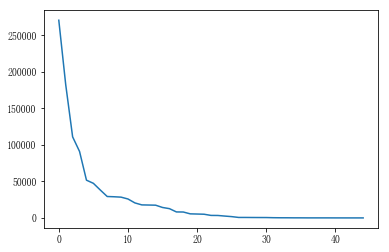

看看哪些优惠券是经常被领的


(45, 2)

0       1
0     30:5  270712
1   100:10  182554
2   200:20  111046
3     20:5   91013
4     20:1   51705
5     50:5   47379
6   100:30   38196
7   200:30   29327
8   300:30   28979
9    50:10   28452
10    10:5   25925
11    0.95   20568
12    10:1   17842
13    30:1   17654
14  150:20   17437

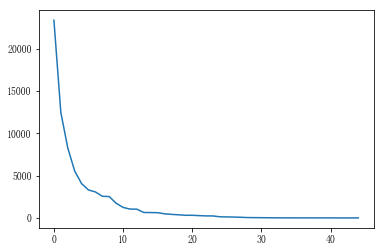

看看哪些优惠券是经常被领的


(45, 2)

0      1
0     30:5  23368
1     20:5  12471
2     20:1   8280
3   100:10   5550
4     10:1   4054
5     10:5   3302
6     50:5   3073
7     30:1   2561
8     0.95   2521
9   200:20   1731
10   50:10   1242
11  100:20   1047
12  100:30   1033
13     5:1    641
14     0.8    635

In [3]:
###优惠券和距离
off_train.Discount_rate.unique()
off_train.Distance.unique()

print('毫无疑问，基本上都是“满多少，减多少”的优惠券')

#每种类型消费券出现的次数
X = []
Y = []
for rate_type in (off_train.Discount_rate.unique()):
    if rate_type != -1:
        x = rate_type
        y = off_train[off_train.Discount_rate == rate_type].Discount_rate.count()

        X.append(x)
        Y.append(y)
    
df_tem = pd.DataFrame([X, Y]).T
df_tem = df_tem.sort_values(by=1, ascending = False).reset_index(drop=True)

df_tem[1].plot()
plt.show()

print('看看哪些优惠券是经常被领的')
df_tem.shape
df_tem.head(15)


##优惠券核销的次数
X = []
Y = []
for rate_type in (off_train.Discount_rate.unique()):
    if rate_type != -1:
        x = rate_type
        y = off_train[(off_train.Discount_rate == rate_type) & (off_train.Date != -1)].Discount_rate.count()

        X.append(x)
        Y.append(y)
    
df_tem = pd.DataFrame([X, Y]).T
df_tem = df_tem.sort_values(by=1, ascending = False).reset_index(drop=True)

df_tem[1].plot()
plt.show()

print('看看哪些优惠券是经常被领的')
df_tem.shape
df_tem.head(15)

In [4]:
coupon_byDate = off_train[off_train['Date_received'] != -1].groupby(['User_id', 'Date_received'], as_index=False)[['Merchant_id']].count()
coupon_byDate.columns = ['User_id', 'Date_received','count']

buy_byDate = off_train[(off_train['Date'] != -1) & (off_train['Date_received'] != -1)].groupby(['User_id', 'Date'], as_index=False)[['Merchant_id']].count()
buy_byDate.columns = ['User_id', 'Date','count']

coupon_byDate.head()
buy_byDate.head()

print('在这些领了券的人当中，每一天倒是会领很多次，但是基本上一天当中只会消费一次')

User_id  Date_received  count
0        4     20160214.0      1
1        4     20160607.0      1
2       35     20160129.0      2
3       35     20160130.0      2
4       36     20160125.0      2

User_id        Date  count
0      184  20160228.0      1
1      417  20160412.0      1
2      687  20160130.0      1
3      687  20160402.0      1
4      696  20160413.0      1

在这些领了券的人当中，每一天倒是会领很多次，但是基本上一天当中只会消费一次


In [5]:
# 测试集中出现，但训练集没出现

print('用户：', len(set(off_test.User_id) - set(off_train.User_id)))
print('商店：', len(set(off_test.Merchant_id) - set(off_train.Merchant_id)))
print('优惠券：', len(set(off_test.Coupon_id) - set(off_train.Coupon_id)))

print('\n')
print('测试集上的数据，基本train上都有覆盖')

用户： 2
商店： 1
优惠券： 932


测试集上的数据，基本train上都有覆盖


In [6]:
###正样本
posi_sample_offLine = off_train[(off_train.Coupon_id != -1) & (off_train.Date != -1)]
posi_sample_offLine.shape

###负样本
navi_sample_offLine = off_train[(off_train.Coupon_id != -1) & (off_train.Date == -1)]
navi_sample_offLine.shape

(75382, 7)

(977900, 7)

In [7]:
tem = sorted(on_train.Date_received.unique())
print('online训练集，领取优惠券的最早时期：', tem[1])
print('online训练集，领取优惠券的最后时期：', tem[-1])


print('\n')
tem = sorted(off_train.Date_received.unique())
print('offline训练集，领取优惠券的最早时期：', tem[1])
print('offline训练集，领取优惠券的最后时期：', tem[-1])


print('\n')
tem = sorted(on_train.Date.unique())
print('online训练集，消费的最早时期：', tem[1])
print('online训练集，消费的最后时期：', tem[-1])


print('\n')
tem = sorted(off_train.Date.unique())
print('offline训练集，消费的最早时期：', tem[1])
print('offline训练集，消费的最后时期：', tem[-1])


print('\n')
tem = sorted(off_test.Date_received.unique())
print('offline测试集，领取优惠券的最早时期：', tem[0])
print('offline测试集，领取优惠券的最后时期：', tem[-1])

online训练集，领取优惠券的最早时期： 20160101.0
online训练集，领取优惠券的最后时期： 20160615.0


offline训练集，领取优惠券的最早时期： 20160101.0
offline训练集，领取优惠券的最后时期： 20160615.0


online训练集，消费的最早时期： 20160101.0
online训练集，消费的最后时期： 20160630.0


offline训练集，消费的最早时期： 20160101.0
offline训练集，消费的最后时期： 20160630.0


offline测试集，领取优惠券的最早时期： 20160701
offline测试集，领取优惠券的最后时期： 20160731


In [8]:
print('on_train:')
print('有优惠券， 购买商品：', on_train[(on_train['Coupon_id'] != -1) & (on_train['Date'] != -1)].shape[0])
print('有优惠券， 没有购买商品：', on_train[(on_train['Coupon_id'] != -1) & (on_train['Date'] == -1)].shape[0])
print('无优惠券， 购买商品：', on_train[(on_train['Coupon_id'] == -1) & (on_train['Date'] != -1)].shape[0])
print('无优惠券， 没有购买商品：', on_train[(on_train['Coupon_id'] == -1) & (on_train['Date'] == -1)].shape[0])
print('\n')

print('off_train:')
print('有优惠券， 购买商品：', off_train[(off_train['Coupon_id'] != -1) & (off_train['Date'] != -1)].shape[0])
print('有优惠券， 没有购买商品：', off_train[(off_train['Coupon_id'] != -1) & (off_train['Date'] == -1)].shape[0])
print('无优惠券， 购买商品：', off_train[(off_train['Coupon_id'] == -1) & (off_train['Date'] != -1)].shape[0])
print('无优惠券， 没有购买商品：', off_train[(off_train['Coupon_id'] == -1) & (off_train['Date'] == -1)].shape[0])
print('\n')

on_train:
有优惠券， 购买商品： 216459
有优惠券， 没有购买商品： 655898
无优惠券， 购买商品： 10557469
无优惠券， 没有购买商品： 0


off_train:
有优惠券， 购买商品： 75382
有优惠券， 没有购买商品： 977900
无优惠券， 购买商品： 701602
无优惠券， 没有购买商品： 0




In [9]:
print('on_train的人数：', len(set(on_train.User_id)))
print('off_train的人数：', len(set(off_train.User_id)))
print('off_train和on_train的人数交集：', len(set(on_train.User_id) & set(off_train.User_id)))

print('\n')
print('on_train的商户数：', len(set(on_train.Merchant_id)))
print('off_train的商户数：', len(set(off_train.Merchant_id)))
print('off_train和on_train的商户数交集：', len(set(on_train.Merchant_id) & set(off_train.Merchant_id)))

print('\n')
print('on_train的优惠券数：', len(set(on_train.Coupon_id)))
print('off_train的优惠券数：', len(set(off_train.Coupon_id)))
print('off_train和on_train的优惠券数交集：', len(set(on_train.Coupon_id) & set(off_train.Coupon_id)))


print('\n')
print('off_test的人数：', len(set(off_test.User_id)))
print('off_train和off_test的人数交集：', len(set(off_train.User_id) & set(off_test.User_id)))

print('\n')
print('on_train的优惠券数：', on_train.Coupon_id.nunique())
print('off_train的优惠券数：', off_train.Coupon_id.nunique())
print('off_train领取优惠券的记录数：', off_train[off_train.Coupon_id != -1].shape[0])
print('off_test的优惠券数：', off_test.Coupon_id.nunique())
print('off_test领取优惠券的记录数：', off_test[off_test.Coupon_id != -1].shape[0])

on_train的人数： 762858
off_train的人数： 539438
off_train和on_train的人数交集： 267448


on_train的商户数： 7999
off_train的商户数： 8415
off_train和on_train的商户数交集： 0


on_train的优惠券数： 27748
off_train的优惠券数： 9739
off_train和on_train的优惠券数交集： 1


off_test的人数： 76309
off_train和off_test的人数交集： 76307


on_train的优惠券数： 27748
off_train的优惠券数： 9739
off_train领取优惠券的记录数： 1053282
off_test的优惠券数： 2050
off_test领取优惠券的记录数： 113640


#### 数据预处理

In [2]:
###原始数据加载###################################################
on_train = pd.read_csv(input_path + 'ccf_online_stage1_train.csv')
off_train = pd.read_csv(input_path + 'ccf_offline_stage1_train.csv')
off_test = pd.read_csv(input_path + 'ccf_offline_stage1_test_revised.csv')

#空值填-1
on_train = on_train.fillna(-1)
off_train = off_train.fillna(-1)
off_test = off_test.fillna(-1)

###数据集划分#####################################################
###测试集数据
df_test = off_test
# df_test = df_test.groupby(['User_id']).apply(lambda x: x.sort_values('Date_received')).reset_index(drop=True)

df_test_feat_offline = off_train[((off_train.Date_received != -1) & (off_train.Date_received >= 20160315) & (off_train.Date_received <= 20160630)) | 
                                 ((off_train.Date != -1) & (off_train.Date >= 20160315) & (off_train.Date <= 20160630))]
df_test_feat_online = on_train[((on_train.Date_received != -1) & (on_train.Date_received >= 20160315) & (on_train.Date_received <= 20160630)) | 
                               ((on_train.Date != -1) & (on_train.Date >= 20160315) & (on_train.Date <= 20160630))]

print('df_test.shape:', df_test.shape)


###训练集_1数据
df_train1 = off_train[(off_train.Date_received != -1) & (off_train.Date_received >= 20160515) & (off_train.Date_received <= 20160615)]
# df_train1 = df_train1.groupby(['User_id']).apply(lambda x: x.sort_values('Date_received')).reset_index(drop=True)

df_train1_feat_offline = off_train[((off_train.Date_received != -1) & (off_train.Date_received >= 20160201) & (off_train.Date_received <= 20160514)) | 
                                  ((off_train.Date != -1) & (off_train.Date >= 20160201) & (off_train.Date <= 20160514))]
df_train1_feat_online = on_train[((on_train.Date_received != -1) & (on_train.Date_received >= 20160201) & (on_train.Date_received <= 20160514)) | 
                                ((on_train.Date != -1) & (on_train.Date >= 20160201) & (on_train.Date <= 20160514))]

print('df_train1.shape:', df_train1.shape)

###训练集_2数据
df_train2 = off_train[(off_train.Date_received != -1) & (off_train.Date_received >= 20160414) & (off_train.Date_received <= 20160514)]
# df_train2 = df_train2.groupby(['User_id']).apply(lambda x: x.sort_values('Date_received')).reset_index(drop=True)

df_train2_feat_offline = off_train[((off_train.Date_received != -1) & (off_train.Date_received >= 20160101) & (off_train.Date_received <= 20160413)) | 
                                  ((off_train.Date != -1) & (off_train.Date >= 20160101) & (off_train.Date <= 20160413))]
df_train2_feat_online = on_train[((on_train.Date_received != -1) & (on_train.Date_received >= 20160101) & (on_train.Date_received <= 20160413)) | 
                                ((on_train.Date != -1) & (on_train.Date >= 20160101) & (on_train.Date <= 20160413))]                                          

print('df_train2.shape:', df_train2.shape)


###时间格式转化、训练集打标签#####################################################
###train1时间格式转化，打标签
def time_convert(int_time):
    if int_time != -1:
        str_time = str(int(int_time))
        year = int(str_time[0: 4])
        month = int(str_time[4: 6])
        day = int(str_time[6: 8])
        datatime_time = datetime(year, month, day)
    else:
        datatime_time = -1
    
    return datatime_time

df_train1['Date_received'] = df_train1.Date_received.apply(time_convert)  
df_train1['Date'] = df_train1.Date.apply(time_convert)  

df_train1['diff'] = df_train1.apply(lambda x: (x.Date - x.Date_received).days if x.Date != -1 else -1, axis=1)
df_train1['label'] = df_train1['diff'].apply(lambda x: 0 if(x > 15 or x == -1) else 1)

print(df_train1['label'].value_counts())

###train2时间格式转化，打标签
df_train2['Date_received'] = df_train2.Date_received.apply(time_convert)  
df_train2['Date'] = df_train2.Date.apply(time_convert)  

df_train2['diff'] = df_train2.apply(lambda x: (x.Date - x.Date_received).days if x.Date != -1 else -1, axis=1)
df_train2['label'] = df_train2['diff'].apply(lambda x: 0 if(x > 15 or x == -1) else 1)

print(df_train2['label'].value_counts())

###test时间格式转化
df_test['Date_received'] = df_test.Date_received.apply(time_convert)



###预处理完的数据保存#######################################################
pickle.dump(df_test, open(input_path + 'df_test.pkl', 'wb'))
pickle.dump(df_test_feat_offline, open(input_path + 'df_test_feat_offline.pkl', 'wb'))
pickle.dump(df_test_feat_online, open(input_path + 'df_test_feat_online.pkl', 'wb'))

pickle.dump(df_train1, open(input_path + 'df_train1.pkl', 'wb'))
pickle.dump(df_train1_feat_offline, open(input_path + 'df_train1_feat_offline.pkl', 'wb'))
pickle.dump(df_train1_feat_online, open(input_path + 'df_train1_feat_online.pkl', 'wb'))

pickle.dump(df_train2, open(input_path + 'df_train2.pkl', 'wb'))
pickle.dump(df_train2_feat_offline, open(input_path + 'df_train2_feat_offline.pkl', 'wb'))
pickle.dump(df_train2_feat_online, open(input_path + 'df_train2_feat_online.pkl', 'wb'))


print('ok')

df_test.shape: (113640, 6)
df_train1.shape: (258446, 7)
df_train2.shape: (137167, 7)
0    235152
1     23294
Name: label, dtype: int64
0    128094
1      9073
Name: label, dtype: int64
ok


#### 特征工程

In [3]:
######################################
def discount_rate_trans(str_rate):
    if str_rate == 'fixed':
        float_rate = 0.9
    else:
        list_ = re.findall('\d*', str_rate)
        a = int(list_[0])
        b = int(list_[2])

        if a != 0: 
            float_rate = (a - b) / a
        else:
            float_rate = float(str_rate)
    
    return float_rate
def discount_rate_man(str_rate):
    if re.search(':', str_rate):
        list_ = re.findall('\d*', str_rate)
        a = int(list_[0])
        b = int(list_[2])
        
        return a
    else:
        return 0
def discount_rate_jian(str_rate):
    if re.search(':', str_rate):
        list_ = re.findall('\d*', str_rate)
        a = int(list_[0])
        b = int(list_[2])
        
        return b
    else:
        return 0
def time_convert(int_time):
    if int_time != -1:
        str_time = str(int(int_time))
        year = int(str_time[0: 4])
        month = int(str_time[4: 6])
        day = int(str_time[6: 8])
        datatime_time = datetime(year, month, day)
    else:
        datatime_time = -1
    
    return datatime_time

###六大特征群
def user_off_feat(df_train1, df_train1_feat_offline):
    #用户领取优惠券的次数：
    df_tem_feat = df_train1_feat_offline[df_train1_feat_offline.Date_received != -1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Coupon_id'], ['user_received_coupon_count'])

    #用户领取优惠券，但没有消费的次数
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date == -1)].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Coupon_id'], ['user_received_coupon_butNotConsume_count'])

    #用户领取优惠券，而且消费了的次数
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Coupon_id'], ['user_received_coupon_andConsume_count'])

    #用户领取优惠券后的核销率：
    df_train1['user_received_coupon_ConsumeRate'] = df_train1.user_received_coupon_andConsume_count / df_train1.user_received_coupon_count

    #用户核销优惠券的平均折扣率，最大折扣率，最小折扣率 ：
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_tem_feat['Discount_rate'] = df_tem_feat.Discount_rate.apply(discount_rate_trans)
    df_train1 = feat_mean(df_train1, df_tem_feat, ['User_id'], ['Discount_rate'], ['user_consume_coupon_aveDiscountRate'], na=-1)
    df_train1 = feat_max(df_train1, df_tem_feat, ['User_id'], ['Discount_rate'], ['user_consume_coupon_maxDiscountRate'], na=-1)
    df_train1 = feat_min(df_train1, df_tem_feat, ['User_id'], ['Discount_rate'], ['user_consume_coupon_minDiscountRate'], na=-1)

    #用户核销过优惠券的不同商家数量；以及占所有商家的比重：
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_train1 = feat_nunique(df_train1, df_tem_feat, ['User_id'], ['Merchant_id'], ['user_consume_coupon_MerchantNunique'])
    df_train1['user_consume_coupon_MerchantRate'] = df_train1['user_consume_coupon_MerchantNunique'] / df_tem_feat.Merchant_id.nunique()

    #用户核销过的不同优惠券数量；以及占所有核销优惠券的比重：
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_train1 = feat_nunique(df_train1, df_tem_feat, ['User_id'], ['Coupon_id'], ['user_consume_coupon_Nunique'])
    df_train1['user_consume_coupon_Rate'] = df_train1['user_consume_coupon_Nunique'] / df_train1['user_received_coupon_andConsume_count']

    #用户平均核销每个商家多少张优惠券：
    df_train1['user_consume_coupon_AveCount'] = df_train1['user_received_coupon_andConsume_count'] / df_train1['user_consume_coupon_MerchantNunique']

    #用户核销优惠券中，离商家的平均距离，最远距离，最近距离
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date != -1)& 
                                         (df_train1_feat_offline.Distance != -1)].copy()
    df_train1 = feat_mean(df_train1, df_tem_feat, ['User_id'], ['Distance'], ['user_consume_coupon_meanDistance'], na=-1)
    df_train1 = feat_max(df_train1, df_tem_feat, ['User_id'], ['Distance'], ['user_consume_coupon_maxDistance'], na=-1)
    df_train1 = feat_min(df_train1, df_tem_feat, ['User_id'], ['Distance'], ['user_consume_coupon_minDistance'], na=-1)

    return df_train1
def user_on_feat(df_train1, df_train1_feat_online):
    #用户线上消费次数：
    df_tem_feat = df_train1_feat_online[df_train1_feat_online.Action == 1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Action'], ['on_user_action_Consume_count'])
    
    #用户线上不消费次数：
    df_tem_feat = df_train1_feat_online[df_train1_feat_online.Action != 1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Action'], ['on_user_action_notConsume_count'])
    
    #用户线上点击次数，购买次数，领取次数；点击率，购买率，领取率
    df_tem_feat = df_train1_feat_online.copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Action'], ['on_user_action_all_count'])
    
    df_tem_feat = df_train1_feat_online[df_train1_feat_online.Action == 0].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Action'], ['on_user_action_0_count'])
    
    df_tem_feat = df_train1_feat_online[df_train1_feat_online.Action == 1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Action'], ['on_user_action_1_count'])
    
    df_tem_feat = df_train1_feat_online[df_train1_feat_online.Action == 2].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Action'], ['on_user_action_2_count'])
    
    df_train1['on_user_action_0_rate'] = df_train1['on_user_action_0_count'] / df_train1['on_user_action_all_count']
    df_train1['on_user_action_1_rate'] = df_train1['on_user_action_1_count'] / df_train1['on_user_action_all_count']
    df_train1['on_user_action_2_rate'] = df_train1['on_user_action_2_count'] / df_train1['on_user_action_all_count']
    
    #用户线上优惠券的（领取+核销）次数：
    df_tem_feat = df_train1_feat_online[(df_train1_feat_online.Coupon_id != -1)].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Coupon_id'], ['on_user_Coupon_receive_count'])
    
    #用户线上优惠券核销的次数：
    df_tem_feat = df_train1_feat_online[(df_train1_feat_online.Coupon_id != -1) & (df_train1_feat_online.Action == 1)].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Action'], ['on_user_Coupon_andConsume_count'])
    
    #用户线上优惠券核销率：
    df_train1['on_user_received_Consume_rate'] = df_train1['on_user_action_Consume_count'] / (df_train1['on_user_Coupon_receive_count'] + 0.1)
    
    #用户线下不消费的次数，占线上线下总的不消费次数比重
    df_train1['on_notConsume_rate'] = df_train1['user_received_coupon_butNotConsume_count'] / \
                 (df_train1['user_received_coupon_butNotConsume_count'] + df_train1['on_user_action_notConsume_count'] + 0.1)

    #用户线下优惠券核销次数，占线上线下总的优惠券核销次数比重
    df_train1['on_coupon_Consume_rate'] = df_train1['user_received_coupon_andConsume_count'] / \
                 (df_train1['user_received_coupon_andConsume_count'] + df_train1['on_user_Coupon_andConsume_count'] + 0.1)

    #用户线上领取优惠券的次数
    df_tem_feat = df_train1_feat_online[df_train1_feat_online.Action == 2].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id'], ['Coupon_id'], ['on_user_received_coupon_count'])
    
    #用户线下领取优惠券次数，占线上线下领取次数的比重
    df_train1['on_received_coupon_rate'] = df_train1['user_received_coupon_count'] / \
                 (df_train1['user_received_coupon_count'] + df_train1['on_user_received_coupon_count'] + 0.1)
    
    return df_train1
def Merchant_feat(df_train1, df_train1_feat_offline):
    #商家优惠券发放次数
    df_tem_feat = df_train1_feat_offline[df_train1_feat_offline.Coupon_id != -1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['Merchant_id'], ['Coupon_id'], ['Merchant_send_coupon_count'])
    
    #商家优惠券发放的种类
    df_tem_feat = df_train1_feat_offline[df_train1_feat_offline.Coupon_id != -1].copy()
    df_train1 = feat_nunique(df_train1, df_tem_feat, ['Merchant_id'], ['Coupon_id'], ['Merchant_send_coupon_nunique'])
    
    #商家优惠券发放后，不被核销的次数
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Coupon_id != -1) & (df_train1_feat_offline.Date != 1)].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['Merchant_id'], ['Coupon_id'], ['Merchant_send_coupon_butNotConsume_count'])
    
    #商家优惠券发放后，被核销的次数
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Coupon_id != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['Merchant_id'], ['Coupon_id'], ['Merchant_send_coupon_andConsume_count'])

    #商家优惠券发放后，被核销的比率：
    df_train1['Merchant_send_coupon_andConsume_rate'] = df_train1['Merchant_send_coupon_andConsume_count'] / \
                                                        df_train1['Merchant_send_coupon_count']
    
    #商家优惠券核销的平均折率，最大折率，最小折率
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Coupon_id != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_tem_feat['Discount_rate'] = df_tem_feat.Discount_rate.apply(discount_rate_trans)
    df_train1 = feat_mean(df_train1, df_tem_feat, ['Merchant_id'], ['Discount_rate'], ['Merchant_coupon_Consume_aveDiscountRate'], na=-1)
    df_train1 = feat_max(df_train1, df_tem_feat, ['Merchant_id'], ['Discount_rate'], ['Merchant_coupon_Consume_maxDiscountRate'], na=-1)
    df_train1 = feat_min(df_train1, df_tem_feat, ['Merchant_id'], ['Discount_rate'], ['Merchant_coupon_Consume_minDiscountRate'], na=-1)
    
    #核销商家优惠券的，不同用户数量；以及占所有领取次数的比重
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Coupon_id != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_train1 = feat_nunique(df_train1, df_tem_feat, ['Merchant_id'], ['User_id'], ['Merchant_send_coupon_userNunique'])
    df_train1['Merchant_send_coupon_userRate'] = df_train1['Merchant_send_coupon_userNunique'] / df_train1['Merchant_send_coupon_count']
    
    #商家平均每个用户核销优惠券多少张
    df_train1['Merchant_aveUser_CouponCount'] = df_train1['Merchant_send_coupon_andConsume_count'] / df_train1['Merchant_send_coupon_userNunique']
    
    #商家被核销过的不同优惠券数量；
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Coupon_id != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_train1 = feat_nunique(df_train1, df_tem_feat, ['Merchant_id'], ['Coupon_id'], ['Merchant_send_coupon_andConsume_nunique'])
    
    
    #商家被核销过的不同优惠券数量，占所有领取过的不同优惠券比重
    df_train1['Merchant_send_coupon_andConsume_nunique'] = df_train1['Merchant_send_coupon_andConsume_nunique'] / \
                                                               df_train1['Merchant_send_coupon_nunique']
    
    #商家平均每种优惠券核销多少张：
    df_train1['Merchant_aveCoupon_count'] = df_train1['Merchant_send_coupon_andConsume_count'] / df_train1['Merchant_send_coupon_nunique']
    
    #商家被核销的优惠券中，平均，最大，最小距离。
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_train1 = feat_mean(df_train1, df_tem_feat, ['Merchant_id'], ['Distance'], ['Merchant_send_coupon_meanDistance'], na=-1)
    df_train1 = feat_max(df_train1, df_tem_feat, ['Merchant_id'], ['Distance'], ['Merchant_send_coupon_maxDistance'], na=-1)
    df_train1 = feat_min(df_train1, df_tem_feat, ['Merchant_id'], ['Distance'], ['Merchant_send_coupon_minDistance'], na=-1)
    
    #商家被核销的优惠券中，核销的平均时间
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Coupon_id != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_tem_feat.Date = df_tem_feat.Date.apply(time_convert)
    df_tem_feat.Date_received = df_tem_feat.Date_received.apply(time_convert)
    df_tem_feat['diff'] = (df_tem_feat.Date - df_tem_feat.Date_received).dt.days
    df_train1 = feat_mean(df_train1, df_tem_feat, ['Merchant_id'], ['diff'], ['Merchant_coupon_Consume_AveTime'], na=-1)
    
    return df_train1
def user_Merchant_feat(df_train1, df_train1_feat_offline):
    #用户领取商家优惠券的次数
    df_tem_feat = df_train1_feat_offline[df_train1_feat_offline.Date_received != -1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id', 'Merchant_id'], ['Coupon_id'], ['user_get_Merchant_coupon_count'])
    
    #用户领取商家优惠券后，但不核销的次数
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date == -1)].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id', 'Merchant_id'], ['Coupon_id'], ['user_get_Merchant_coupon_notConsume_count'])
    
    #用户领取商家优惠券后，核销的次数
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Date_received != -1) & (df_train1_feat_offline.Date != -1)].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['User_id', 'Merchant_id'], ['Coupon_id'], ['user_get_Merchant_coupon_Consume_count'])
    
    #用户领取商家优惠券后，核销率
    df_train1['user_get_Merchant_coupon_Consume_rate'] = df_train1['user_get_Merchant_coupon_Consume_count'] / df_train1['user_get_Merchant_coupon_count']
    
    #用户对每个商家的不核销次数，占用户总的不核销次数的比重：
    df_train1['userMerchant_notConsume_to_user_notConsume_rate'] = df_train1['user_get_Merchant_coupon_notConsume_count'] / df_train1['user_received_coupon_butNotConsume_count']
    
    #用户对每个商家的核销次数，占用户总的核销次数的比重：
    df_train1['userMerchant_Consume_to_user_Consume_rate'] = df_train1['user_get_Merchant_coupon_Consume_count'] / df_train1['user_received_coupon_andConsume_count']
    
    #用户对每个商家的不核销次数，占商家总的不核销次数的比重：
    df_train1['userMerchant_notConsume_to_Merchant_notConsume_rate'] = df_train1['user_get_Merchant_coupon_notConsume_count'] / df_train1['Merchant_send_coupon_butNotConsume_count']
    
    #用户对每个商家的核销次数，占商家总的核销次数的比重：
    df_train1['userMerchant_Consume_to_Merchant_Consume_rate'] = df_train1['user_get_Merchant_coupon_Consume_count'] / df_train1['Merchant_send_coupon_andConsume_count']
    
    return df_train1
def Coupon_feat(df_train1, df_train1_feat_offline):
    df_train1['discount_rate_type'] = df_train1.Discount_rate.apply(lambda x: 0 if re.search(':', x) else 1)
    df_train1['discount_rate_man'] = df_train1.Discount_rate.apply(discount_rate_man)
    df_train1['discount_rate_jian'] = df_train1.Discount_rate.apply(discount_rate_jian)
    df_train1['Discount_rate'] = df_train1.Discount_rate.apply(discount_rate_trans)
    df_train1['day'] = df_train1.Date_received.dt.day
    df_train1['weekday'] = df_train1.Date_received.dt.weekday
    df_train1['is_weekend'] = df_train1.weekday.apply(lambda x: 1 if x<=4 else 0)
    
    #该优惠券在，历史上出现的次数：
    df_tem_feat = df_train1_feat_offline[df_train1_feat_offline.Coupon_id != -1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['Coupon_id'], ['Merchant_id'], ['Coupon_appear_count'])
    
    #该优惠券在，历史上核销的次数：
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Coupon_id != -1) & df_train1_feat_offline.Date != -1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['Coupon_id'], ['Merchant_id'], ['Coupon_Consume_count'])
    
    #该优惠券在，历史上的核销率：
    df_train1['Coupon_Consume_rate'] = df_train1['Coupon_Consume_count'] / (df_train1['Coupon_appear_count'] + 0.1)

    #历史上，该用户领取该优惠券的次数
    df_tem_feat = df_train1_feat_offline[df_train1_feat_offline.Coupon_id != -1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['Coupon_id', 'User_id'], ['Merchant_id'], ['Coupon_User_appear_count'])
    
    #历史上，该用户领取该优惠券后的核销次数
    df_tem_feat = df_train1_feat_offline[(df_train1_feat_offline.Coupon_id != -1) & df_train1_feat_offline.Date != -1].copy()
    df_train1 = feat_count(df_train1, df_tem_feat, ['Coupon_id', 'User_id'], ['Merchant_id'], ['Coupon_User_Consume_count'])
    
    #历史上，该用户领取该优惠券后的核销率
    df_train1['Coupon_User_Consume_rate'] = df_train1['Coupon_User_Consume_count'] / (df_train1['Coupon_User_appear_count'] + 0.1)
    
    
    return df_train1
def leakage_feat(df_train1):
    #用户领取的所有优惠券数目
    df_train1 = feat_count(df_train1, df_train1, ['User_id'], ['Coupon_id'], ['leak_User_receive_all_Coupon_count'])
    
    #用户领取的相同优惠券数目
    df_train1 = feat_count(df_train1, df_train1, ['User_id', 'Coupon_id'], ['Merchant_id'], ['leak_User_receive_same_Coupon_count'])
    
    #用户领取同一优惠券的最大/最小时间： 
    df_train1_tem = df_train1.groupby(['User_id', 'Coupon_id'])['Merchant_id'].count().reset_index().rename(columns={'Merchant_id': 'count'})
    df_train1_tem = df_train1_tem[df_train1_tem['count'] >= 2]
    df_train1_tem = pd.merge(df_train1, df_train1_tem, on=['User_id', 'Coupon_id'], how='inner')
    df_train1_tem['time'] = df_train1_tem['Date_received'].dt.day
    
    df_train1 = feat_max(df_train1, df_train1_tem, ['User_id', 'Coupon_id'], ['time'], ['leak_User_receive_same_Coupon_maxTime'])
    df_train1 = feat_min(df_train1, df_train1_tem, ['User_id', 'Coupon_id'], ['time'], ['leak_User_receive_same_Coupon_minTime'])
    
    #是否是最后一次领取，是否是第一次领取：
    df_train1['is_last_receive'] = df_train1['leak_User_receive_same_Coupon_maxTime'] - (df_train1['Date_received']).dt.day
    df_train1['is_first_receive'] = (df_train1['Date_received']).dt.day - df_train1['leak_User_receive_same_Coupon_minTime']
    
    def is_firstOrLast_day(diff_day):
        if diff_day == 0:
            return 1
        elif diff_day > 0:
            return 0
        else:
            return -1
    df_train1['is_last_receive'] = df_train1['is_last_receive'].apply(is_firstOrLast_day)
    df_train1['is_first_receive'] = df_train1['is_first_receive'].apply(is_firstOrLast_day)
    
    #用户当天领取的优惠券总数：
    df_train1 = feat_count(df_train1, df_train1, ['User_id', 'Date_received'], ['Coupon_id'], ['leak_User_theDate_received_Coupon_count'])
    
    #用户当天领取相同优惠券总数：
    df_train1 = feat_count(df_train1, df_train1, ['User_id', 'Date_received', 'Coupon_id'], ['Merchant_id'], ['leak_User_theDate_received_Coupon_count'])
    
    #用户领取不同商家数目：
    df_train1 = feat_nunique(df_train1, df_train1, ['User_id'], ['Merchant_id'], ['leak_User_receive_Merchant_nunique'])
    
    #用户领取的所有优惠券种类
    df_train1 = feat_nunique(df_train1, df_train1, ['User_id'], ['Coupon_id'], ['leak_User_receive_Coupon_nunique'])

    #商家被领取的优惠券数目：
    df_train1 = feat_count(df_train1, df_train1, ['Merchant_id'], ['Coupon_id'], ['leak_Merchant_send_Coupon_count'])

    #商家被多少不用用户领取：
    df_train1 = feat_nunique(df_train1, df_train1, ['Merchant_id'], ['User_id'], ['leak_Merchant_get_User_nunique'])
    
    #商家发行的所有优惠券种类：
    df_train1 = feat_nunique(df_train1, df_train1, ['Merchant_id'], ['Coupon_id'], ['leak_Merchant_send_Coupon_nunique'])
    
    #同一张优惠券，用户这次领取与上一次/下一次领取的时间间隔：（超级强特）
    def get_day_gap_before(the_DateReceived_all_DateReceived):
        the_DateReceived, all_DateReceived = the_DateReceived_all_DateReceived.split('-')
        all_DateReceived = all_DateReceived.split(':')

        gaps = []
        for day in all_DateReceived:
            the_gap = (datetime(int(the_DateReceived[0: 4]), int(the_DateReceived[4: 6]), int(the_DateReceived[6: 8])) - 
                       datetime(int(day[0: 4]), int(day[4: 6]), int(day[6: 8]))).days
            if the_gap > 0:
                gaps.append(the_gap)
        if len(gaps) == 0:
            return -1
        else:
            return min(gaps)
    def get_day_gap_after(the_DateReceived_all_DateReceived):
        the_DateReceived, all_DateReceived = the_DateReceived_all_DateReceived.split('-')
        all_DateReceived = all_DateReceived.split(':')

        gaps = []
        for day in all_DateReceived:
            the_gap = (datetime(int(day[0: 4]), int(day[4: 6]), int(day[6: 8])) - 
                       datetime(int(the_DateReceived[0: 4]), int(the_DateReceived[4: 6]), int(the_DateReceived[6: 8]))).days
            if the_gap > 0:
                gaps.append(the_gap)
        if len(gaps) == 0:
            return -1
        else:
            return min(gaps)
    df_train1_tem = df_train1.copy()
    df_train1_tem['Date_received'] = df_train1_tem['Date_received'].apply(lambda x: x.strftime('%Y%m%d'))
    df_train1_tem = df_train1_tem.groupby(['User_id', 'Coupon_id'])['Date_received'].agg(lambda x: ':'.join(x)).reset_index()
    df_train1_tem = df_train1_tem.rename(columns={'Date_received': 'all_DateReceived'})

    df_train1_tem_2 = pd.merge(df_train1, df_train1_tem, on=['User_id', 'Coupon_id'], how='left')
    df_train1_tem_2['Date_received'] = df_train1_tem_2['Date_received'].apply(lambda x: x.strftime('%Y%m%d'))
    df_train1_tem_2['the_DateReceived_all_DateReceived'] = df_train1_tem_2.Date_received + '-' + df_train1_tem_2.all_DateReceived
    df_train1_tem_2['receive_same_Coupon_timeGap_before'] = df_train1_tem_2.the_DateReceived_all_DateReceived.apply(get_day_gap_before)
    df_train1_tem_2['receive_same_Coupon_timeGap_after'] = df_train1_tem_2.the_DateReceived_all_DateReceived.apply(get_day_gap_after)
    df_train1_tem_2 = df_train1_tem_2[['receive_same_Coupon_timeGap_before', 'receive_same_Coupon_timeGap_after']]
    
    df_train1 = pd.concat([df_train1.reset_index(drop=True), df_train1_tem_2.reset_index(drop=True)], axis=1)
    
    #用户这次领取与上一次/下一次领取的时间间隔：
    df_train1_tem = df_train1.copy()
    df_train1_tem['Date_received'] = df_train1_tem['Date_received'].apply(lambda x: x.strftime('%Y%m%d'))
    df_train1_tem = df_train1_tem.groupby(['User_id'])['Date_received'].agg(lambda x: ':'.join(x)).reset_index()
    df_train1_tem = df_train1_tem.rename(columns={'Date_received': 'all_DateReceived'})
    
    df_train1_tem_2 = pd.merge(df_train1, df_train1_tem, on=['User_id'], how='left')
    df_train1_tem_2['Date_received'] = df_train1_tem_2['Date_received'].apply(lambda x: x.strftime('%Y%m%d'))
    df_train1_tem_2['the_DateReceived_all_DateReceived'] = df_train1_tem_2.Date_received + '-' + df_train1_tem_2.all_DateReceived
    df_train1_tem_2['receive_Coupon_timeGap_before'] = df_train1_tem_2.the_DateReceived_all_DateReceived.apply(get_day_gap_before)
    df_train1_tem_2['receive_Coupon_timeGap_after'] = df_train1_tem_2.the_DateReceived_all_DateReceived.apply(get_day_gap_after)
    df_train1_tem_2 = df_train1_tem_2[['receive_Coupon_timeGap_before', 'receive_Coupon_timeGap_after']]
    
    df_train1 = pd.concat([df_train1.reset_index(drop=True), df_train1_tem_2.reset_index(drop=True)], axis=1)
    
    
    #同一张优惠券，用户此次之前/之后领取的所有优惠券数目：
    def get_Coupon_count_before(the_DateReceived_all_DateReceived):
        the_DateReceived, all_DateReceived = the_DateReceived_all_DateReceived.split('-')
        all_DateReceived = all_DateReceived.split(':')

        gaps = []
        for day in all_DateReceived:
            the_gap = (datetime(int(the_DateReceived[0: 4]), int(the_DateReceived[4: 6]), int(the_DateReceived[6: 8])) - 
                       datetime(int(day[0: 4]), int(day[4: 6]), int(day[6: 8]))).days
            if the_gap > 0:
                gaps.append(the_gap)
        if len(gaps) == 0:
            return -1
        else:
            return len(gaps)
    def get_Coupon_count_after(the_DateReceived_all_DateReceived):
        the_DateReceived, all_DateReceived = the_DateReceived_all_DateReceived.split('-')
        all_DateReceived = all_DateReceived.split(':')

        gaps = []
        for day in all_DateReceived:
            the_gap = (datetime(int(day[0: 4]), int(day[4: 6]), int(day[6: 8])) - 
                       datetime(int(the_DateReceived[0: 4]), int(the_DateReceived[4: 6]), int(the_DateReceived[6: 8]))).days
            if the_gap > 0:
                gaps.append(the_gap)
        if len(gaps) == 0:
            return -1
        else:
            return len(gaps)
    df_train1_tem = df_train1.copy()
    df_train1_tem['Date_received'] = df_train1_tem['Date_received'].apply(lambda x: x.strftime('%Y%m%d'))
    df_train1_tem = df_train1_tem.groupby(['User_id', 'Coupon_id'])['Date_received'].agg(lambda x: ':'.join(x)).reset_index()
    df_train1_tem = df_train1_tem.rename(columns={'Date_received': 'all_DateReceived'})

    df_train1_tem_2 = pd.merge(df_train1, df_train1_tem, on=['User_id', 'Coupon_id'], how='left')
    df_train1_tem_2['Date_received'] = df_train1_tem_2['Date_received'].apply(lambda x: x.strftime('%Y%m%d'))
    df_train1_tem_2['the_DateReceived_all_DateReceived'] = df_train1_tem_2.Date_received + '-' + df_train1_tem_2.all_DateReceived
    df_train1_tem_2['receive_sameCoupon_count_before'] = df_train1_tem_2.the_DateReceived_all_DateReceived.apply(get_Coupon_count_before)
    df_train1_tem_2['receive_sameCoupon_count_after'] = df_train1_tem_2.the_DateReceived_all_DateReceived.apply(get_Coupon_count_after)
    df_train1_tem_2 = df_train1_tem_2[['receive_sameCoupon_count_before', 'receive_sameCoupon_count_after']]
    
    df_train1 = pd.concat([df_train1.reset_index(drop=True), df_train1_tem_2.reset_index(drop=True)], axis=1)
    
    #用户此次之前/之后领取的所有优惠券数目：
    df_train1_tem = df_train1.copy()
    df_train1_tem['Date_received'] = df_train1_tem['Date_received'].apply(lambda x: x.strftime('%Y%m%d'))
    df_train1_tem = df_train1_tem.groupby(['User_id'])['Date_received'].agg(lambda x: ':'.join(x)).reset_index()
    df_train1_tem = df_train1_tem.rename(columns={'Date_received': 'all_DateReceived'})
    
    df_train1_tem_2 = pd.merge(df_train1, df_train1_tem, on=['User_id'], how='left')
    df_train1_tem_2['Date_received'] = df_train1_tem_2['Date_received'].apply(lambda x: x.strftime('%Y%m%d'))
    df_train1_tem_2['the_DateReceived_all_DateReceived'] = df_train1_tem_2.Date_received + '-' + df_train1_tem_2.all_DateReceived
    df_train1_tem_2['receive_Coupon_count_before'] = df_train1_tem_2.the_DateReceived_all_DateReceived.apply(get_Coupon_count_before)
    df_train1_tem_2['receive_Coupon_count_after'] = df_train1_tem_2.the_DateReceived_all_DateReceived.apply(get_Coupon_count_after)
    df_train1_tem_2 = df_train1_tem_2[['receive_Coupon_count_before', 'receive_Coupon_count_after']]
    
    df_train1 = pd.concat([df_train1.reset_index(drop=True), df_train1_tem_2.reset_index(drop=True)], axis=1)

    
    return df_train1


###################################################################################
if __name__ =='__main__':
    ###数据加载###############################
    df_test = pickle.load(open(input_path + 'df_test.pkl', 'rb'))
    df_test_feat_offline = pickle.load(open(input_path + 'df_test_feat_offline.pkl', 'rb'))
    df_test_feat_online = pickle.load(open(input_path + 'df_test_feat_online.pkl', 'rb'))

    df_train1 = pickle.load(open(input_path + 'df_train1.pkl', 'rb'))
    df_train1_feat_offline = pickle.load(open(input_path + 'df_train1_feat_offline.pkl', 'rb'))
    df_train1_feat_online = pickle.load(open(input_path + 'df_train1_feat_online.pkl', 'rb'))

    df_train2 = pickle.load(open(input_path + 'df_train2.pkl', 'rb'))
    df_train2_feat_offline = pickle.load(open(input_path + 'df_train2_feat_offline.pkl', 'rb'))
    df_train2_feat_online = pickle.load(open(input_path + 'df_train2_feat_online.pkl', 'rb'))
    
    
    start_time = time()
    ##########用户线下特征群；线上得分（0.5218），线下得分（0.5800）
    df_train1 = user_off_feat(df_train1, df_train1_feat_offline)
    df_train2 = user_off_feat(df_train2, df_train2_feat_offline)
    df_test = user_off_feat(df_test, df_test_feat_offline)

    ########用户线上特征群；线上得分（0.5992），线下得分（）
    df_train1 = user_on_feat(df_train1, df_train1_feat_online)
    df_train2 = user_on_feat(df_train2, df_train2_feat_online)
    df_test = user_on_feat(df_test, df_test_feat_online)

    ########商店特征群；线上得分（0.5998），线下得分（0.5781）
    df_train1 = Merchant_feat(df_train1, df_train1_feat_offline)
    df_train2 = Merchant_feat(df_train2, df_train2_feat_offline)
    df_test = Merchant_feat(df_test, df_test_feat_offline)
    
    ########用户商家交互特征群；
    df_train1 = user_Merchant_feat(df_train1, df_train1_feat_offline)
    df_train2 = user_Merchant_feat(df_train2, df_train2_feat_offline)
    df_test = user_Merchant_feat(df_test, df_test_feat_offline)

    #########优惠券特征群；线上得分（）
    df_train1 = Coupon_feat(df_train1, df_train1_feat_offline)
    df_train2 = Coupon_feat(df_train2, df_train2_feat_offline)
    df_test = Coupon_feat(df_test, df_test_feat_offline)
    
    ##########leakage特征群；线上得分（0.7683），线下得分（0.7504）
    df_train1 = leakage_feat(df_train1)
    df_train2 = leakage_feat(df_train2)
    df_test = leakage_feat(df_test)
    

    print('提取特征的时间为:', int(time() - start_time))
    
    df_train1.shape
    df_train2.shape
    df_test.shape
    print('ok')

提取特征的时间为: 175


(258446, 98)

(137167, 98)

(113640, 95)

ok


#### 跑模型

##### 20%随机验证集

In [8]:
###训练集、验证集############
X_train1 = df_train1.drop(['label', 'Date_received', 'Date', 'diff', 'User_id', 'Merchant_id'], axis=1)
y_train1 = df_train1['label']

X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train1, y_train1, test_size=0.2, random_state=1254)
df_Coupon_y = pd.concat([X_val_.Coupon_id, y_val_], axis=1)

# 奇怪，为什么id特征加进去分数提高那么多，是leak吗？？
X_train = X_train1.drop(['Coupon_id'], axis=1)
X_train_ = X_train_.drop(['Coupon_id'], axis=1)
X_val_ = X_val_.drop(['Coupon_id'], axis=1)


###测试集###################
X_test = df_test.drop(['User_id', 'Merchant_id', 'Coupon_id',  'Date_received',], axis=1)

In [9]:
###模型训练预测
def clf_train(X_train, y_train, X_val, y_val):
    categorical_feature = ['性别', '入院科室']
    clf = lgb.LGBMClassifier(n_estimators=10000,
                                   learning_rate=0.06,
                                   max_depth=5,
                                   num_leaves=30,
                                   objective='binary',
                                   subsample=0.8,
                                   sub_feature=0.8,
#                                    class_weight='balanced',  #设置样本平衡；好像不要会更好
                                   )
    clf.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)], eval_metric='binary_logloss',
            early_stopping_rounds=100, verbose = 5000,
#             categorical_feature = categorical_feature    #onehot之后就不需要了
            )
    feat_impo = sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)
    return clf, feat_impo 
def clf_predict(clf, X_val):
    y_pred = clf.predict_proba(X_val, num_iteration=clf.best_iteration)
    
    return y_pred
def clf_evaluate(df_Coupon_y, y_pred):
    y_pred = y_pred[:, 1]  #因为sklearn输出每个类别的概率，手动选择1类
    
    df_val_auc = df_Coupon_y[['Coupon_id', 'label']]
    df_val_auc['pred_prob'] = y_pred

    # 计算平均AUC
    vg = df_val_auc.groupby(['Coupon_id'])
    aucs = []
    for i in vg:   #这个“i”是分好组子集
        df_tem = i[1]

        if len(df_tem['label'].unique()) != 2:
            continue

        fpr, tpr, thresholds = roc_curve(df_tem['label'], df_tem['pred_prob'], pos_label=1)
        aucs.append(auc(fpr, tpr))
    print('平均auc为：', np.average(aucs))


start_time = time()

clf, feat_impo = clf_train(X_train_, y_train_, X_val_, y_val_)
y_pred = clf_predict(clf, X_val_)
clf_evaluate(df_Coupon_y, y_pred)

print('训练预测的时间为:', int(time() - start_time))

Train until valid scores didn't improve in 100 rounds.
Early stopping, best iteration is:
[904]	valid_0's binary_logloss: 0.183722
平均auc为： 0.8017468961530861
训练预测的时间为: 40


##### 划分数据集做验证集
训练集：train2；验证集train1

In [10]:
X_train1 = df_train1.drop(['label', 'Date_received', 'Date', 'diff', 'User_id', 'Coupon_id', 'Merchant_id'], axis=1)
y_train1 = df_train1['label']

X_train2 = df_train2.drop(['label', 'Date_received', 'Date', 'diff', 'User_id', 'Coupon_id', 'Merchant_id'], axis=1)
y_train2 = df_train2['label']

X_test = df_test.drop(['Date_received', 'User_id', 'Coupon_id', 'Merchant_id'], axis=1)


###递归特征消除
seltor, X_train2, X_train1, X_test = RFECV_feature_sel(X_train2, y_train2, X_train1, X_test)

###树模型特征选择
# feat_import, X_train2, X_train1, X_test = Tree_feature_select(X_train2, y_train2, X_train1, y_train1, X_test, 80)

X_train2.shape
X_train1.shape
X_test.shape

(137167, 91)

(258446, 91)

(113640, 91)

In [11]:
###模型训练预测
def clf_train(X_train, y_train, X_val, y_val):
    categorical_feature = ['性别', '入院科室']
    clf = lgb.LGBMClassifier(n_estimators=10000,
                                   learning_rate=0.06,
                                   max_depth=5,
                                   num_leaves=30,
                                   objective='binary',
                                   subsample=0.9,
                                   sub_feature=0.9,
#                                    class_weight='balanced',  #设置样本平衡；好像不要会更好
                                   )
    clf.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)], eval_metric='binary_logloss',
            early_stopping_rounds=100, verbose = 100,
#             categorical_feature = categorical_feature    #onehot之后就不需要了
            )
#     feat_impo = sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)
    feat_impo = 1
    return clf, feat_impo 
def clf_predict(clf, X_val):
    y_pred = clf.predict_proba(X_val, num_iteration=clf.best_iteration)
    
    return y_pred
def clf_evaluate(df_Coupon_y, y_pred):
    y_pred = y_pred[:, 1]  #因为sklearn输出每个类别的概率，手动选择1类
    
    df_val_auc = df_Coupon_y[['Coupon_id', 'label']]
    df_val_auc['pred_prob'] = y_pred

    # 计算平均AUC
    vg = df_val_auc.groupby(['Coupon_id'])
    aucs = []
    for i in vg:   #这个“i”是分好组子集
        df_tem = i[1]

        if len(df_tem['label'].unique()) != 2:
            continue

        fpr, tpr, thresholds = roc_curve(df_tem['label'], df_tem['pred_prob'], pos_label=1)
        aucs.append(auc(fpr, tpr))
    print('平均auc为：', np.average(aucs))


start_time = time()

clf, feat_impo = clf_train(X_train2, y_train2, X_train1, y_train1)
y_pred = clf_predict(clf, X_train1)
clf_evaluate(df_train1, y_pred)

print('训练预测的时间为:', int(time() - start_time))

Train until valid scores didn't improve in 100 rounds.
[100]	valid_0's binary_logloss: 0.231941
[200]	valid_0's binary_logloss: 0.233949
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.231472
平均auc为： 0.7504008583682287
训练预测的时间为: 12


##### 线上提交

In [17]:
def clf_train(X_train, y_train, X_val, y_val):
    clf = lgb.LGBMClassifier(n_estimators=180,
                             learning_rate=0.06,
                             max_depth=5,
                             num_leaves=30,
                             objective='binary',
                             subsample=0.9,
                             sub_feature=0.9,
#                            class_weight='balanced',  #设置样本平衡；好像不要会更好
                             )
    clf.fit(X_train, y_train, 
#             eval_set=[(X_val, y_val)], eval_metric='binary_logloss',
#             early_stopping_rounds=100000, verbose = 5000,
#             categorical_feature = categorical_feature    #onehot之后就不需要了
            )
#     feat_impo = sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)
    feat_impo = 1
    return clf, feat_impo 
def clf_predict(clf, X_val):
    y_pred = clf.predict_proba(X_val, num_iteration=180)
    
    return y_pred

# ###单分数据集
# clf, feat_impo = clf_train(X_train1, y_train1, X_train1, y_train1)
# y_pred = clf_predict(clf, X_test)
# y_pred = y_pred[:, 1]


###数据集合并
X_train1 = pd.DataFrame(X_train1)
X_train2 = pd.DataFrame(X_train2)
X_train_all = pd.concat([X_train1, X_train2]).reset_index(drop=True)
y_train_all = pd.concat([y_train1, y_train2]).reset_index(drop=True)

clf, feat_impo = clf_train(X_train_all, y_train_all, X_train1, y_train1)
y_pred = clf_predict(clf, X_test)
y_pred = y_pred[:, 1]

submission = pd.read_csv(input_path + 'ccf_offline_stage1_test_revised.csv')[['User_id', 'Coupon_id', 'Date_received']]
df_tem = pd.DataFrame(y_pred, columns=['Probability'])
submission = pd.concat([submission, df_tem], axis=1)

submission.to_csv(submi_path + '8_11_all_恢复原来，保证不错误！！！.csv', index =False, header=None)
print('ok')

ok


#### 可能用到的代码保存

In [ ]:
    #用户此次之后/之前领取的所有优惠券数目：
    def after_Coupon_count(df_user):
        count = df_user.shape[0]
        df_user['leak_after_User_receive_Coupon_count'] = list(range(count-1, -1, -1))
        df_user['leak_pre_User_receive_Coupon_count'] = list(range(0, count))

        return df_user
    df_train1 = df_train1.groupby(['User_id']).apply(after_Coupon_count).reset_index(drop=True)


    #用户上一次/下一次领取的时间间隔：
    def receive_Coupon_gap(df_user):
        df_user['shift_up'] = df_user['Date_received'].shift(-1)
        df_user['shift_down'] = df_user['Date_received'].shift(1)
#         df_user['receive_Coupon_gap_pre'] = (df_user['Date_received'] - df_user['shift_down']).dt.days.fillna(-1)
#         df_user['receive_Coupon_gap_after'] = (df_user['shift_up'] - df_user['Date_received']).dt.days.fillna(-1)

        return df_user
    df_train1 = df_train1.groupby(['User_id']).apply(receive_Coupon_gap).reset_index(drop=True)
    df_train1 = df_train1.drop(['shift_up', 'shift_down'], axis=1)

In [ ]:
df_train1 = pickle.load(open(input_path + 'df_train1.pkl', 'rb'))
df_train1_tem = df_train1.copy()[0: 50]

#用户上一次/下一次领取的时间间隔：
def receive_Coupon_gap(df_user):
    df_user['shift_up'] = df_user['Date_received'].shift(-1)
    df_user['shift_down'] = df_user['Date_received'].shift(1)
    df_user['receive_Coupon_gap_pre'] = (df_user['Date_received'] - df_user['shift_down']).dt.days.fillna(-1)
    df_user['receive_Coupon_gap_after'] = (df_user['shift_up'] - df_user['Date_received']).dt.days.fillna(-1)
    
    global i
    i += 1
    if i%10000 == 0:
        print(i)
    
    return df_user

i = 0
df_train1 = df_train1.groupby(['User_id']).apply(receive_Coupon_gap).reset_index(drop=True)
df_train1 = df_train1.drop(['shift_up', 'shift_down'], axis=1)

In [ ]:
#用户此次“之后”/“之前”领取的所有优惠券数目
df_all_user_tem = pd.DataFrame(columns=['User_id', 'leak_after_User_receive_Coupon_count', 'leak_pre_User_receive_Coupon_count'])
user_set = df_train1.User_id.unique()
i = 0
for user in user_set:
    df_user_tem = df_train1[df_train1.User_id == user].copy()[['User_id']]
    count = df_user_tem.shape[0]
    df_user_tem['leak_after_User_receive_Coupon_count'] = list(range(count-1, -1, -1))
    df_user_tem['leak_pre_User_receive_Coupon_count'] = list(range(0, count))
    df_all_user_tem = pd.concat([df_all_user_tem, df_user_tem]).reset_index(drop=True)
    i += 1
    print(i)
df_all_user_tem = df_all_user_tem.drop('User_id', axis=1)
df_train1 = pd.concat([df_train1, df_all_user_tem], axis=1)

In [ ]:
df_train = pickle.load(open(input_path + 'df_train.pkl', 'rb'))
df_train.head()

df_train_feat_offline = pickle.load(open(input_path + 'df_train_feat_offline.pkl', 'rb'))
df_tem_feat = df_train_feat_offline[df_train_feat_offline.Date_received != -1]
df_tem_feat.head(5)

In [ ]:
##################################
pickle.dump(df_test, open(input_path + 'df_test.pkl', 'wb'))
pickle.dump(df_test_feat_offline, open(input_path + 'df_test_feat_offline.pkl', 'wb'))
pickle.dump(df_test_feat_online, open(input_path + 'df_test_feat_online.pkl', 'wb'))

pickle.dump(df_train, open(input_path + 'df_train.pkl', 'wb'))
pickle.dump(df_train_feat_offline, open(input_path + 'df_train_feat_offline.pkl', 'wb'))
pickle.dump(df_train_feat_online, open(input_path + 'df_train_feat_online.pkl', 'wb'))

###数据加载###############################
df_test = pickle.load(open(input_path + 'df_test.pkl', 'rb'))
df_test_feat_offline = pickle.load(open(input_path + 'df_test_feat_offline.pkl', 'rb'))
df_test_feat_online = pickle.load(open(input_path + 'df_test_feat_online.pkl', 'rb'))

df_train = pickle.load(open(input_path + 'df_train.pkl', 'rb'))
df_train_feat_offline = pickle.load(open(input_path + 'df_train_feat_offline.pkl', 'rb'))
df_train_feat_online = pickle.load(open(input_path + 'df_train_feat_online.pkl', 'rb'))

In [ ]:
# ###转化为时间格式
# on_train['Date_received'] = on_train.Date_received.apply(lambda x: \
#                                 datetime(int(str(x)[0: 4]), int(str(x)[4: 6]), int(str(x)[6: 8])) if x != -1 else -1)   

# off_train['Date_received'] = off_train.Date_received.apply(lambda x: \
#                                 datetime(int(str(x)[0: 4]), int(str(x)[4: 6]), int(str(x)[6: 8])) if x != -1 else -1)   

# off_test['Date_received'] = off_test.Date_received.apply(lambda x: \
#                                 datetime(int(str(x)[0: 4]), int(str(x)[4: 6]), int(str(x)[6: 8])) if x != -1 else -1)   

# on_train['Date'] = on_train.Date.apply(lambda x: \
#                                 datetime(int(str(x)[0: 4]), int(str(x)[4: 6]), int(str(x)[6: 8])) if x != -1 else -1)   

# off_train['Date'] = off_train.Date.apply(lambda x: \
#                                 datetime(int(str(x)[0: 4]), int(str(x)[4: 6]), int(str(x)[6: 8])) if x != -1 else -1)  

In [14]:
a_list = [[1,2,3],[2,1,3],[7,8,3],[1,2,7]]

df = pd.DataFrame(a_list)
df

df.groupby([0])[[1]].sum().reset_index()

grou = [0]
stati = [1]
name = ['hahah']
df.groupby(grou)[stati].agg('sum').reset_index().rename(columns={stati[0]: name[0]})

0  1  2
0  1  2  3
1  2  1  3
2  7  8  3
3  1  2  7

0  1
0  1  4
1  2  1
2  7  8

0  hahah
0  1      4
1  2      1
2  7      8